# 드라이브 마운트 및 모듈 import



In [ ]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

print("numpy      = ", np.__version__)
print("panda      = ", pd.__version__)
print("tensorflow = ", tf.__version__)
print("matplotlib = ", mpl.__version__)

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings(action='ignore')

numpy      =  1.21.6
panda      =  1.3.5
tensorflow =  2.8.0
matplotlib =  3.2.2


# 데이터 불러오기, 전처리

In [ ]:
exchangerateData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/exchange.csv')     #date column 없음
kospiData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/kospi.csv')               #date column 없음
priceData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/priceindex.xlsx')       #date column 없음
unemployData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/unemployment.xlsx')  #date column 없음

ex_inflationData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/expected_inflation.csv') #date 2002 02 시작
rateData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/new_rate.xlsx')                #date 1999 05 시작 #new_rate 활용
nxM2FrbData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/NX_M2_FRD.xlsx')            #date 1999 05

#Date column이름 변경
ex_inflationData.rename(columns={'Unnamed: 0':'Date','inflation':'Ex_inflation'}, inplace=True)
rateData.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
nxM2FrbData.rename(columns={'Unnamed: 0':'Date','nx':'NX'}, inplace=True)
exchangerateData=exchangerateData[['Close']].rename(columns={'Close':'Exchange_Close'})
kospiData=kospiData[['Close']].rename(columns={'Close':'Kospi_Close'})
priceData=priceData[['Change']].rename(columns={'Change':'Price_Change'})
unemployData=unemployData[['unemployment']].rename(columns={'unemployment':'Unemployment_rate'})

#Date 가져오기
date=rateData[['Date']]

#date 없는 애들 합치기
df_sub=pd.concat([date,exchangerateData,kospiData,priceData,unemployData],axis=1)

#Y data 설정
rateData.loc[rateData['difference'] == 0,'Y']=0     #기준금리 동결 시 0
rateData.loc[rateData['difference'] > 0,'Y']=1      #기준금리 인상 시 1
rateData.loc[rateData['difference'] < 0,'Y']=2      #기준금리 인하 시 2
rateData=rateData[['Date','CD rate','Y']].rename(columns={'CD rate':'CD_rate'})

#index 기준 합치기
df_Main=pd.merge(pd.merge(df_sub,nxM2FrbData),pd.merge(ex_inflationData,rateData))
df_Main=df_Main.dropna() #결측치 삭제

#Date datetime type 변환
df_Main_date=df_Main[['Date']].astype('str')
df_Main_date['Date']=df_Main_date['Date'].apply(lambda _ : dt.datetime.strptime(_,'%Y%m').strftime('%Y-%m'))
df_Main[['Date']]=df_Main_date

#증가율 변환
non_changeColumnsList=['Exchange_Close','Kospi_Close','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']
df_Main[non_changeColumnsList]=df_Main[non_changeColumnsList].pct_change()
df_Main=df_Main.dropna() #증가율 변환 후 결측치 삭제
df_Main.reset_index(drop=True,inplace=True) #결측치 삭제 후 index 재배열

#MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_Main[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']])
df_Main.loc[:,1:-1] = scaled_values

#x_data는 전 월, y_data는 후 월 설정
df_data=df_Main[['Date','Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']]
df_baserate=df_Main[['Date','Y']]
df_baserate.rename(columns={'Date':'Y_Date'},inplace=True)

df_edit1=df_data.loc[0:238].reset_index(drop=True)        #2002 03 ~ 2022 01
df_edit2=df_baserate.loc[1:239].reset_index(drop=True)    #2002 04 ~ 2022 02
df_Main_edit=pd.concat([df_edit1,df_edit2],axis=1)        #x_data와 y_data는 1개월 차  

#출력
df_Main_edit

,Date,Exchange_Close,Kospi_Close,Price_Change,Unemployment_rate,NX,M2,FRB_rate,Ex_inflation,CD_rate,Y_Date,Y
0,2002-03,0.496494,0.864266,0.684211,0.239024,0.488579,0.972928,0.444444,0.510795,0.571227,2002-04,0.0
1,2002-04,0.406375,0.459201,0.684211,0.190351,0.453478,0.756939,0.444444,0.580000,0.588845,2002-05,1.0
2,2002-05,0.288043,0.472314,0.578947,0.260784,0.457018,0.730750,0.444444,0.509186,0.540696,2002-06,0.0
3,2002-06,0.458342,0.437948,0.315789,0.207812,0.472251,0.568510,0.444444,0.725000,0.547778,2002-07,0.0
4,2002-07,0.418169,0.529060,0.210526,0.454598,0.462970,0.672980,0.444444,0.233977,0.554713,2002-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
234,2021-09,0.567961,0.509082,0.578947,0.408333,0.477184,0.448436,0.444444,0.580000,1.000000,2021-10,0.0
235,2021-10,0.462067,0.532578,0.473684,0.406173,0.471127,0.637521,0.444444,0.580000,0.708075,2021-11,1.0
236,2021-11,0.515481,0.499603,0.631579,0.241667,0.471958,0.727401,0.444444,0.960625,0.676080,2021-12,0.0
237,2021-12,0.506459,0.748461,0.473684,0.875000,0.472304,0.504753,0.444444,0.467222,0.679734,2022-01,1.0


# 그림 그려보기

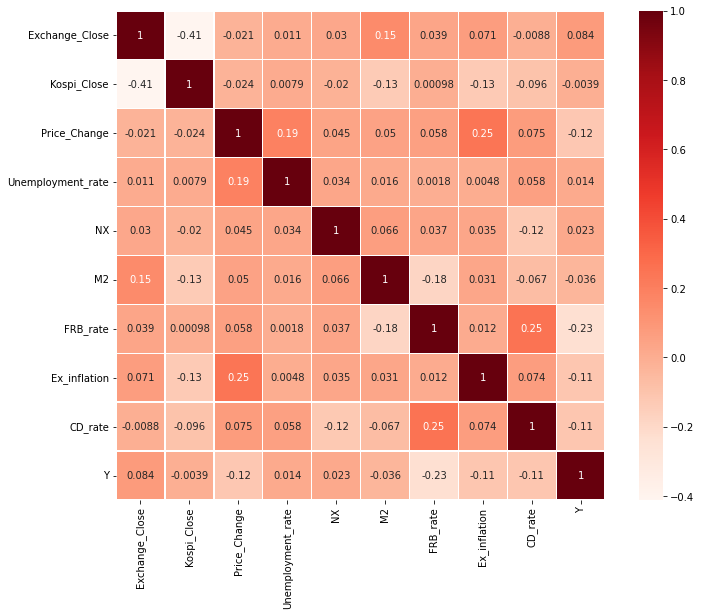

In [ ]:
df_Main_edit=df_Main_edit[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate','Y']]
correlation_matrix = df_Main_edit.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,annot=True,square=True, linewidths=.5,cmap=plt.cm.Reds)
plt.show()

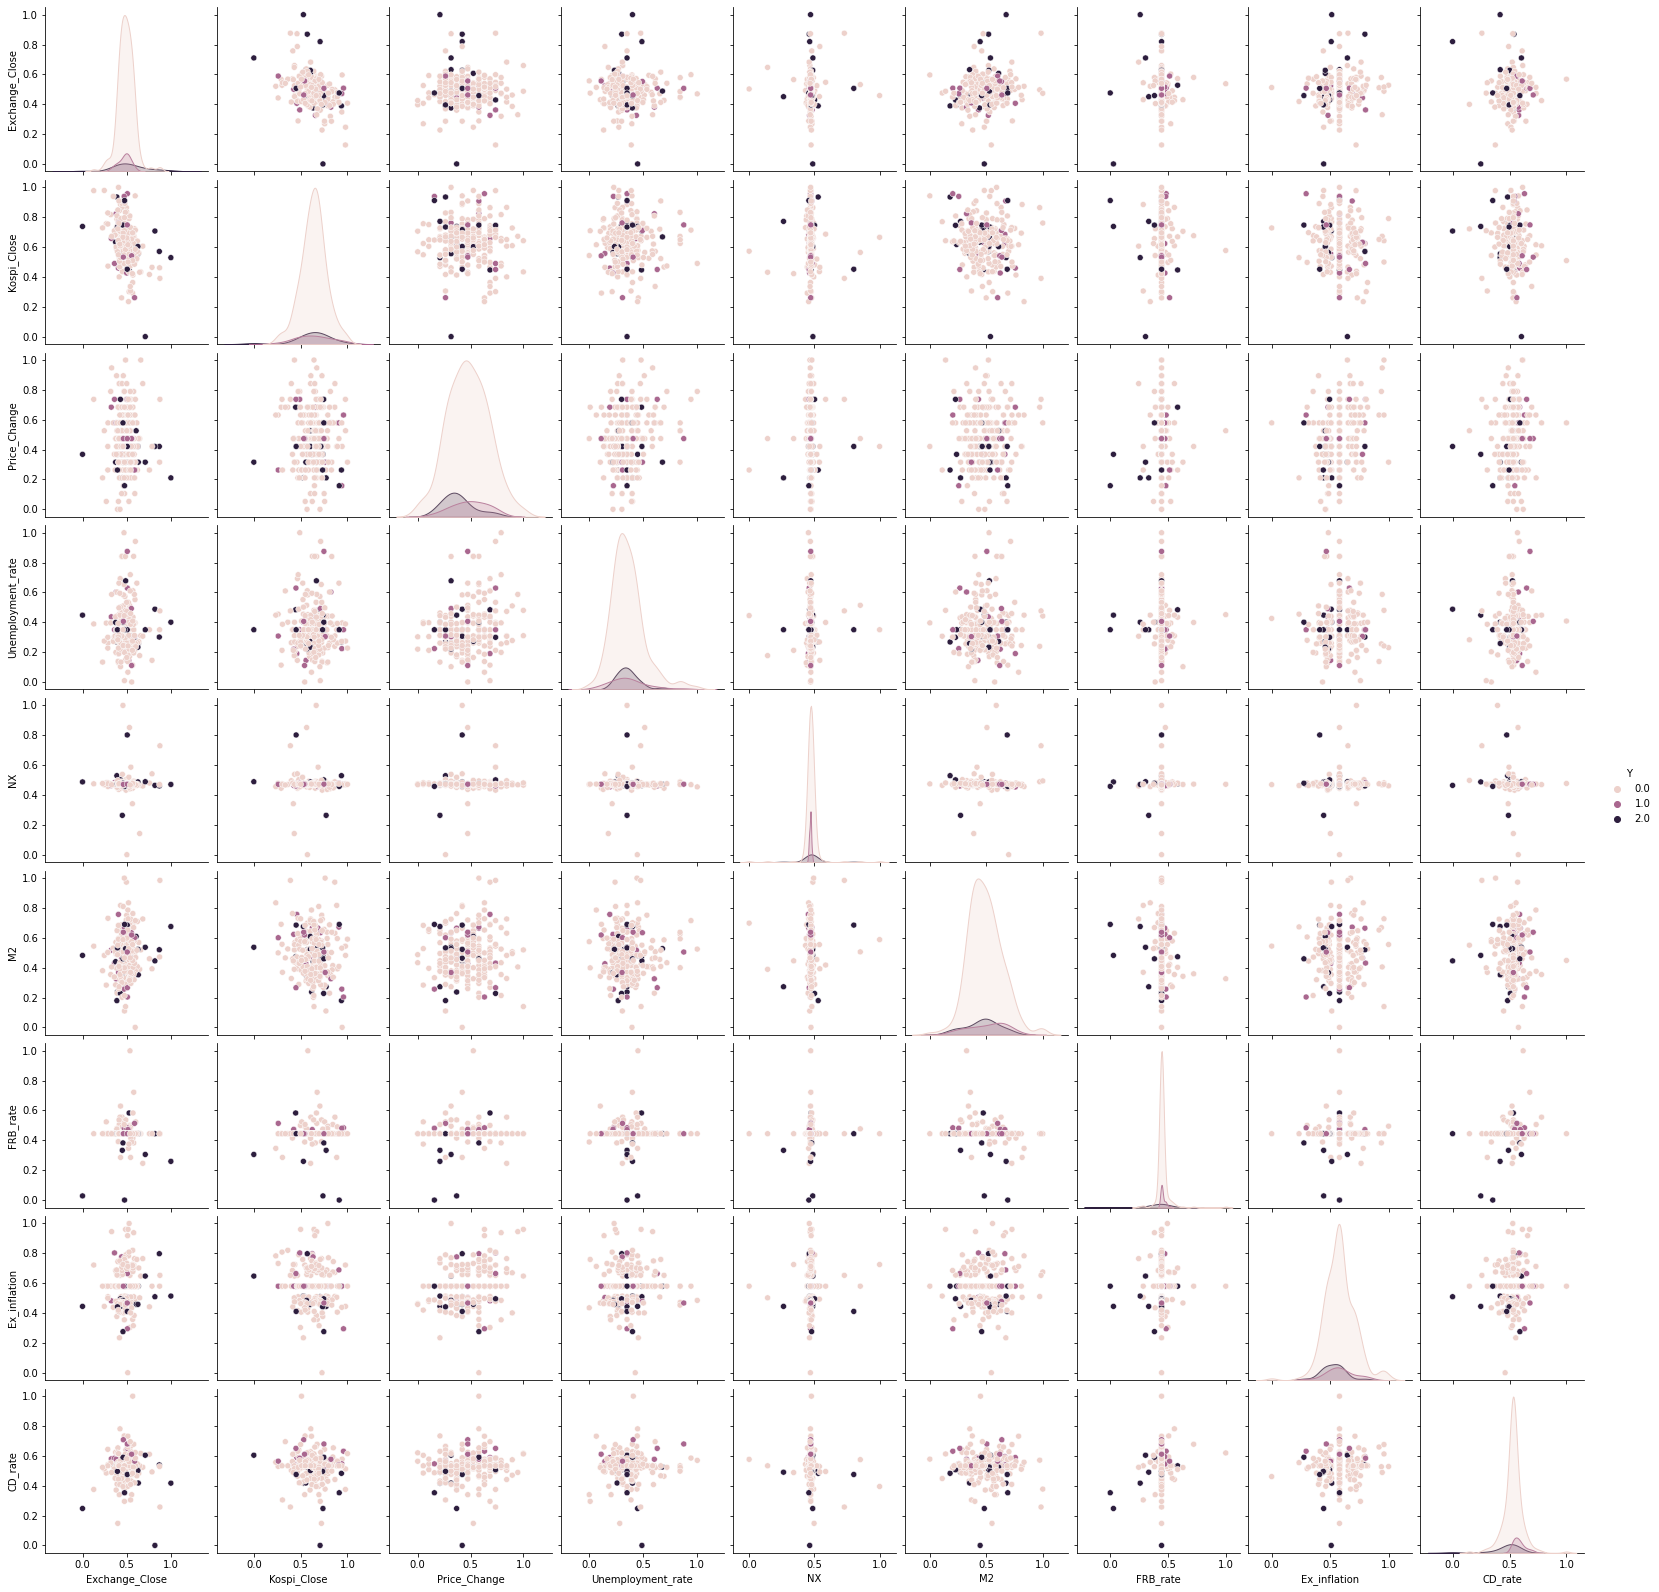

In [ ]:
sns.pairplot(df_Main_edit, hue='Y');
plt.show()

# 오버샘플링

In [ ]:
df_Main_edit["Y"].value_counts()

0.0    199
2.0     21
1.0     19
Name: Y, dtype: int64

In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 11.3 MB/s 
     |████████████████████████████████| 199 kB 38.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
x_data = df_Main_edit[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']].values

y_data = df_Main_edit[['Y']].values
print(x_data.dtype, y_data.dtype)

x_data = x_data.astype('float32')
y_data = y_data.astype('float32')
print(x_data.dtype, y_data.dtype, y_data.shape, x_data.shape)

float64 float64
float32 float32 (239, 1) (239, 9)


Class=0, n=199 (33.333%)
Class=1, n=199 (33.333%)
Class=2, n=199 (33.333%)


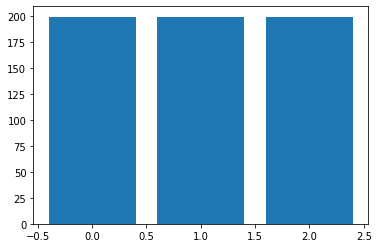

(597,)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
x_data,y_data=SMOTE(random_state=0).fit_resample(x_data,y_data)
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    plt.bar(counter.keys(), counter.values())
    plt.show()

count_and_plot(y_data)
y_data.shape

# 분석

In [ ]:
one_hot_dummy = tf.one_hot(y_data, depth=3).numpy()
y_data = one_hot_dummy
print(y_data.shape)

(597, 3)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,train_size=0.7, shuffle=True) #, random_state=1)

In [ ]:
# HyperParameters
nb_samples = x_train.shape[0] # the number of samples, 417
nb_features= x_train.shape[1] # the number of input variables, 9
nb_classes = y_train.shape[1] # the number of output group, 3    print(nb_inputs, nb_classes)
print(nb_samples ,nb_features, nb_classes)

learning_rate=0.1
epochs = 100001
#display_step   = 1000
batch_size = nb_samples

417 9 3


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# build model
model = Sequential()
model.add(Dense(units=nb_classes, activation='softmax', input_shape=(nb_features,))) # units = output 갯수, input_shape = input 갯수
#model.add(Dense(units=nb_classes, activation='softmax', input_dim=nb_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',       # y_train = one-hot encoding
              optimizer=SGD(learning_rate),
              metrics=['accuracy'])

In [ ]:
# 학습
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) # validation_split=0.2validation_data=(x_test, y_test)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 11ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97503/100001
1/1 [==============================] - 0s 12ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97504/100001
1/1 [==============================] - 0s 9ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97505/100001
1/1 [==============================] - 0s 11ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97506/100001
1/1 [==============================] - 0s 9ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97507/100001
1/1 [==============================] - 0s 11ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97508/100001
1/1 [==============================] - 0s 8ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97509/100001
1/1 [==============================] - 0s 12ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97510/100001
1/1 [==============================] - 0s 9ms/step - loss: 0.7695 - accuracy: 0.6930
Epoch 97511/100001
1/1 [==================

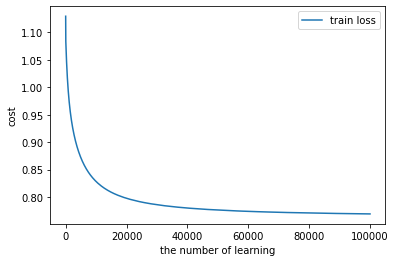

In [ ]:
plt.plot(history.history['loss'],     label = 'train loss')
#plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('the number of learning')
plt.ylabel('cost')
plt.legend()
plt.show()

In [ ]:
w_hat, b_hat = model.get_weights()
print("weights = \n", w_hat)
print("bias = ", b_hat)

weights = 
 [[ 0.83666044 -4.9458566   4.3854938 ]
 [-0.5882761   1.2135638  -0.8104685 ]
 [ 1.6149027   0.7819224  -1.5897163 ]
 [ 0.95805484 -2.1111646   1.6568244 ]
 [-1.6036823  -2.936223    5.31735   ]
 [-0.20104282  3.3876913  -4.2898374 ]
 [ 1.787865    7.161729   -7.4490185 ]
 [ 1.474759    2.1189814  -5.093037  ]
 [-7.4605017  17.444344   -9.797592  ]]
bias =  [  2.5767474 -11.981673    9.404823 ]


In [ ]:
# evaluation, 평가
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:',     score[0])
print('Train accuracy:', score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

Train loss: 0.7692915797233582
Train accuracy: 0.6930455565452576
Test loss: 0.860676646232605
Test accuracy: 0.6555555462837219


[[ 65  35  39]
 [  8 128   6]
 [ 40   0  96]]


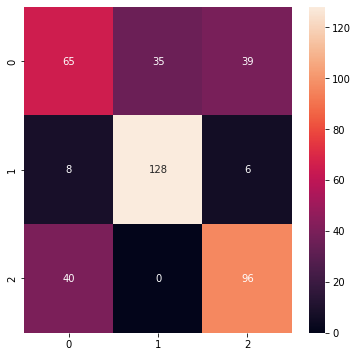

train
Report = 
               precision    recall  f1-score   support

           0       0.58      0.47      0.52       139
           1       0.79      0.90      0.84       142
           2       0.68      0.71      0.69       136

    accuracy                           0.69       417
   macro avg       0.68      0.69      0.68       417
weighted avg       0.68      0.69      0.68       417

test
Report = 
               precision    recall  f1-score   support

           0       0.59      0.33      0.43        60
           1       0.65      0.82      0.73        57
           2       0.69      0.81      0.74        63

    accuracy                           0.66       180
   macro avg       0.64      0.66      0.63       180
weighted avg       0.64      0.66      0.63       180



In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
#y_test = tf.one_hot(y_test, depth=nb_classes)

plt.figure(figsize=(6,6))
predict_value = model.predict(x_train)
cm = confusion_matrix(np.argmax(y_train, axis=-1), np.argmax(predict_value, axis=-1))
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print('train')
from sklearn.metrics import classification_report
y_actual    = np.argmax(y_train, axis=-1)
y_predicted = np.argmax(predict_value, axis=-1)
print('Report = \n', classification_report(y_actual, y_predicted))

print('test')
predict_value = model.predict(x_test)
y_actual    = np.argmax(y_test, axis=-1)
y_predicted = np.argmax(predict_value, axis=-1)
print('Report = \n', classification_report(y_actual, y_predicted))
# macro avg, 단순평균
# weighted avg, 각 셀에 속하는 표본의 갯수로 가중평균

train
[2 0 2 0 1 1 1 1 1 2]
[0 0 0 2 1 1 1 0 1 2]


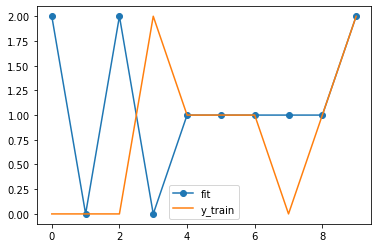

test
[1 2 0 2 0 2 2 2 1 2]
[1 1 0 2 0 0 2 0 0 0]


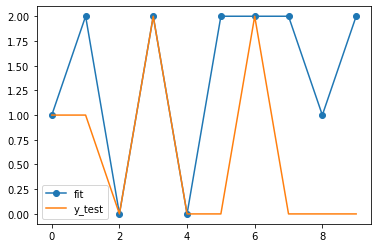

In [ ]:
print('train')
train_pred = model.predict(x_train[:10])
train_value = tf.argmax(train_pred, axis=1).numpy()
print(tf.argmax(train_pred,axis=1).numpy())
print(tf.argmax(y_train[:10], axis=1).numpy())
y_origin = tf.argmax(y_train[:10], axis=1).numpy()

plt.plot(train_value, '-o', label='fit')
plt.plot(y_origin, '-', label='y_train')
plt.legend()
plt.show()


print('test')
test_pred = model.predict(x_test[:10])
test_value = tf.argmax(test_pred, axis=1).numpy()
print(tf.argmax(test_pred,axis=1).numpy())
print(tf.argmax(y_test[:10], axis=1).numpy())
y_origin = tf.argmax(y_test[:10], axis=1).numpy()

plt.plot(test_value, '-o', label='fit')
plt.plot(y_origin, '-', label='y_test')
plt.legend()
plt.show()